In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D

2024-03-04 10:56:01.200568: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 10:56:01.922713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-04 10:56:03.361369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Read data

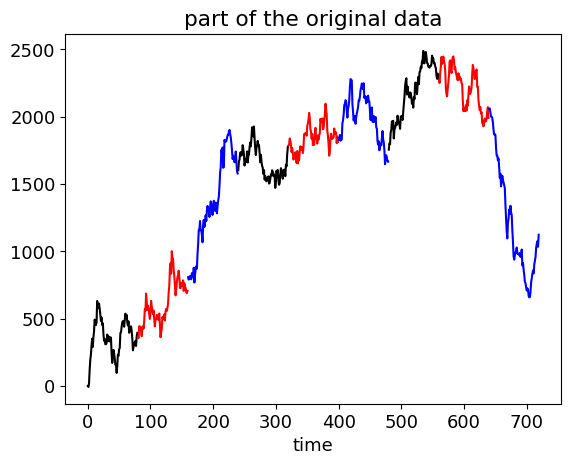

data:  4000


In [3]:
def Show_data(x,L,s="data",T=3):
    c=("k","r","b")
    for i in range(T):
        j=i*3*L
        plt.plot(np.arange(j,j+L),x[i*3],c=c[0])
        plt.plot(np.arange(j+L,j+2*L),x[i*3+1],c=c[1])
        plt.plot(np.arange(j+2*L,j+3*L),x[i*3+2],c=c[2])
    plt.title(s)
    plt.xlabel("time")
    plt.show()
    
str0="ts_L80_N4000.dat"
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,"part of the original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

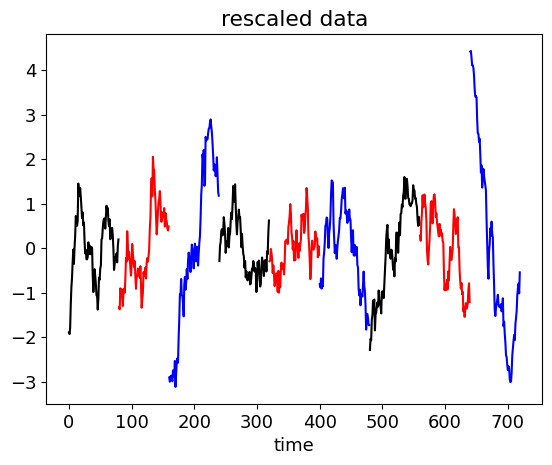

N_train= 3200   N_val= 800   L= 80   n_class= 3


In [4]:
#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
# bring each sample to zero average
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale (crude version, variance should be used)
x = x / x.std()
    
Show_data(x,L,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)  ## THIS IS ASKED BY KERAS TO BE LIKE THIS, EVEN IF YOU HAVE A 1 LAYER

## Convolutional NN

In [5]:
# ...LESSON ...
# reproducibility
np.random.seed(12345)
import tensorflow.random as tf_r
tf_r.set_seed(12345)

NCONV=1

def build_model(NCONV=1, NF=5,KS=6, NF2=5,KS2=4, lamb=0):
    """
    filter = kernel
    NCONV=index of the CNN architecture
    NF=nr of filters in the 1st layer
    KS=kernel size in the 1st layer
    NF2=nr of filters in the 2nd layer
    KS2=kernel size in the 2nd layer
    lamb=not the animal, but lambda, the regularization parameter
    """
    # regularizers, l2=Ridge, l1=LASSO
    reg = keras.regularizers.l2(lamb)
    model = Sequential()

    # Version with last layer Dense
    if NCONV==1:
        model.add(Conv1D(filters=NF,   ## FIRST CONVOLUTION
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(MaxPooling1D(3)) ## POOLING
        #model.add(AveragePooling1D(3))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu')) ## SECOND CONVOLUTION     
        model.add(Flatten()) ## FLATTENING
        model.add(Dense(12, activation='relu')) ## THE OUTPUT TO THIS POINT IS FED TO A 1-LAYER DENSE NEURAL NETWORK    
        model.add(Dropout(0.2))

    # Version with last layer GlobalMaxPooling, one more intermediate conv1D, and no intermediate pooling
    if NCONV==2:
        model.add(Conv1D(filters=NF, 
                         kernel_size=KS,
                         kernel_regularizer=reg,
                         activation='relu', 
                         input_shape=input_shape))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu'))
        model.add(Conv1D(filters=NF2, kernel_size=KS2,activation='relu')) ## THIRD CONVOLUTION
        model.add(tf.keras.layers.GlobalMaxPooling1D()) ## GLOBAL MAX POOLING MEANS THAT YOU TAKE THE MAXIMUM CONVOLUTION AND YOU DO POOLING ON THAT
        model.add(Flatten())
        
    # Last layer, with n_class units  
    model.add(Dense(n_class, activation='softmax')) # softmax !
    
    # optimizers
    # .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
    # .RMSprop()
    # .Nadam()
    # Define the optimizer learning rate as a hyperparameter.
    opt = keras.optimizers.Adam()  ## I SET THE OPTIMIZER TO BE ADAM
    
    # compile the model
    # categorical_crossentropy, 3 output nodes
    model.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])  ## SET LOSS FUNCTION TO BE CATEGORICAL CROSS ENTROPY
    return model

model=build_model(NCONV=NCONV,KS=11)


print('----- Model',NCONV,'-----')
print(model.summary())

# optimizers
# .SGD(lr=0.01, momentum=0.9, nesterov=True) # decay=1e-6,
# .RMSprop()
# .Nadam()
opt = tf.keras.optimizers.Adam()

# compile the model
# categorical_crossentropy, 3 output nodes
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,metrics=['accuracy'])

print(model.layers)

----- Model 1 -----


/home/pietromalagoli/anaconda3/envs/lcpB/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2024-03-04 11:03:21.995270: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-04 11:03:21.995835: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 70, 5)          │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 23, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 5)          │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │         1,212 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,416 (5.53 KB)

 Trainable params: 1,416 (5.53 KB)

 Non-trainable params: 0 (0.00 B)

None
[<Conv1D name=conv1d, built=True>, <MaxPooling1D name=max_pooling1d, built=True>, <Conv1D name=conv1d_1, built=True>, <Flatten name=flatten, built=True>, <Dense name=dense, built=True>, <Dropout name=dropout, built=True>, <Dense name=dense_1, built=True>]


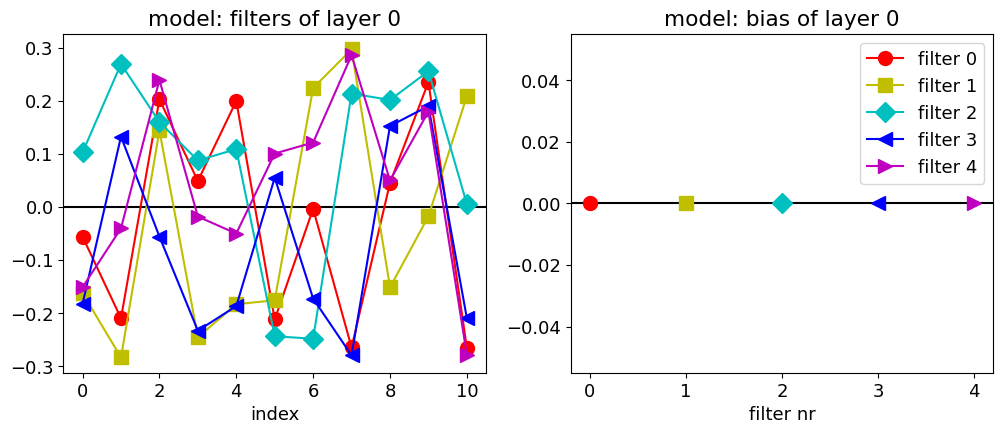

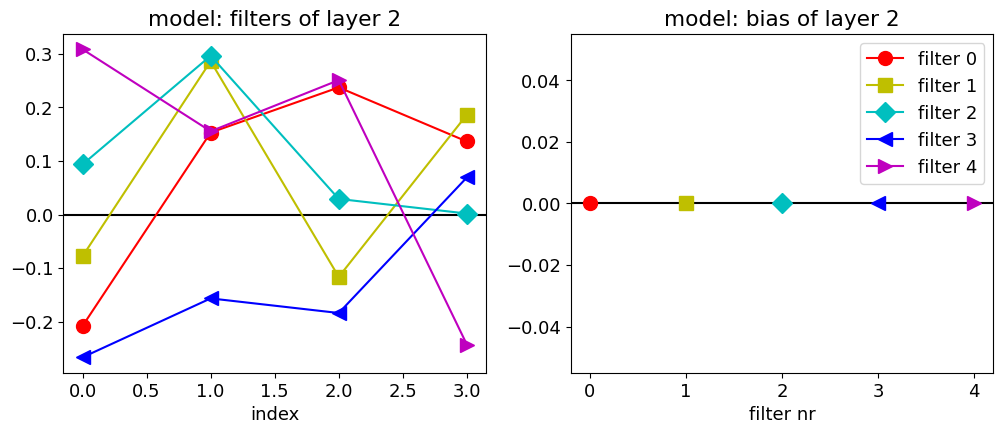

In [6]:
def Show_weights(model,l=0,label="model"):  ## JUST TO VISUALIZE THE WEIGHTS AND BIASES
    c=['r','y','c','b','m','k',"gray","cyan","g"]
    m=['o','s','D','<','>','^','+','x','d',"*"]
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i%len(c)],marker=m[i%len(m)],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i%len(c)],marker=m[i%len(m)],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

In [7]:
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 
BATCH_SIZE = 200
EPOCHS = 300

print('----- Model ',NCONV,'-----\nFITTING....')
fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,  ## TRAINING, THROUGH BATCHES
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=2, shuffle=True) 
print("end of fit")

----- Model  1 -----
FITTING....
Epoch 1/300
16/16 - 2s - 99ms/step - accuracy: 0.3331 - loss: 1.1057 - val_accuracy: 0.3325 - val_loss: 1.1020
Epoch 2/300
16/16 - 0s - 8ms/step - accuracy: 0.3487 - loss: 1.0986 - val_accuracy: 0.3300 - val_loss: 1.1013
Epoch 3/300
16/16 - 0s - 8ms/step - accuracy: 0.3481 - loss: 1.0977 - val_accuracy: 0.3350 - val_loss: 1.1000
Epoch 4/300
16/16 - 0s - 9ms/step - accuracy: 0.3641 - loss: 1.0961 - val_accuracy: 0.3325 - val_loss: 1.1001
Epoch 5/300
16/16 - 0s - 9ms/step - accuracy: 0.3628 - loss: 1.0940 - val_accuracy: 0.3325 - val_loss: 1.0989
Epoch 6/300
16/16 - 0s - 9ms/step - accuracy: 0.3706 - loss: 1.0930 - val_accuracy: 0.3375 - val_loss: 1.0984
Epoch 7/300
16/16 - 0s - 8ms/step - accuracy: 0.3781 - loss: 1.0917 - val_accuracy: 0.3388 - val_loss: 1.0978
Epoch 8/300
16/16 - 0s - 8ms/step - accuracy: 0.3669 - loss: 1.0910 - val_accuracy: 0.3475 - val_loss: 1.0971
Epoch 9/300
16/16 - 0s - 8ms/step - accuracy: 0.3741 - loss: 1.0886 - val_accuracy: 0.

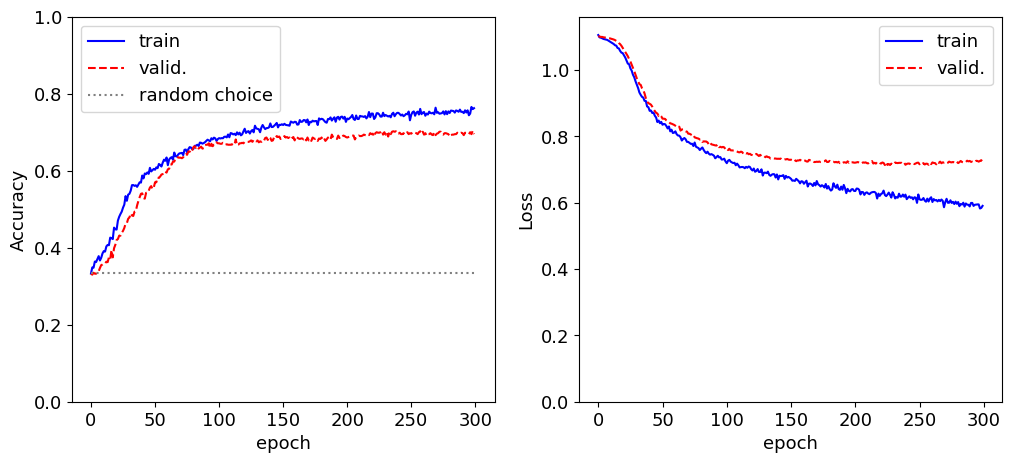

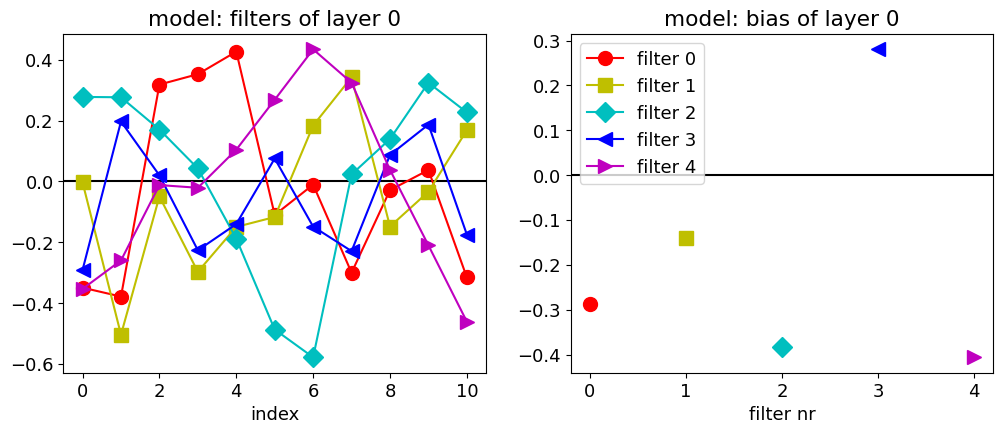

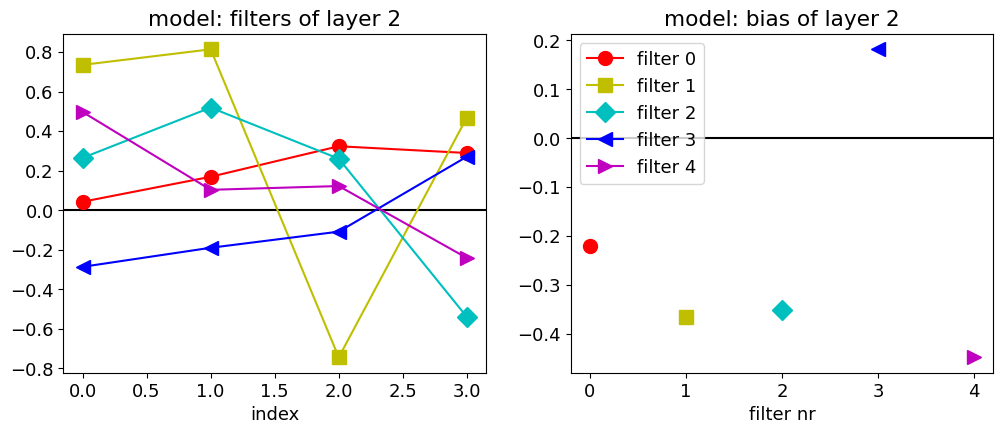

In [8]:
def Show_history(fit): ## PLOTS THE FINAL WEIGHTS THROUGH VALIDATION AND TRAINING
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

## FOR LARGE EPOCHS, THE VALIDITION LOSS STARTS GOING UP -> OVERFITTING -> SOLUTION: EARLY STOPPING
## DID WE NEED ALL THOSE WEIGHTS AND FILTERS? OR WE COULD HAVE USED LESS? OR LESS LENGTH FOR THE WEIGHTS VECTORS?

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


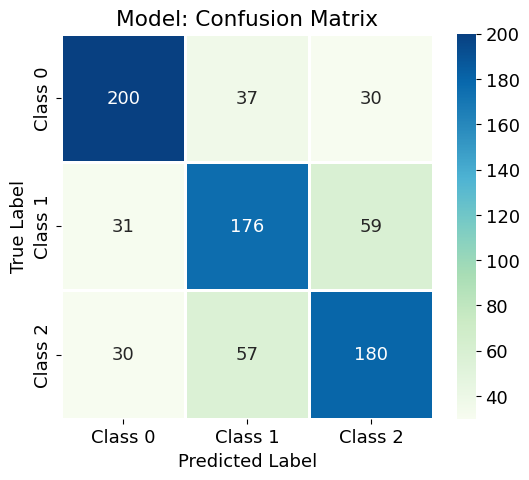

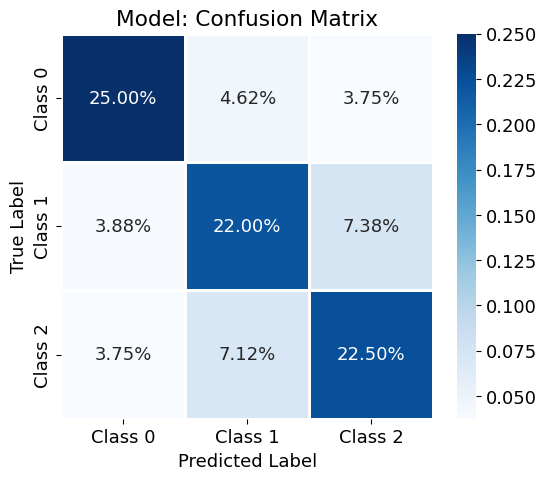

In [9]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["Class 0","Class 1","Class 2"]

def show_confusion_matrix(validations, predictions, label="Model",perc=False):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    M = matrix
    f = 'd'
    cmap="GnBu"
    if perc:
        M=M/np.sum(M)
        f='.2%'
        cmap='Blues'
    seaborn.heatmap(M,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt=f,
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = np.array(model.predict(x_val))
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val,perc=True)

In [17]:
model2 = keras.models.clone_model(model)

reg2 = keras.regularizers.l2(0.5)
model2.layers[0].kernel_regularizer = reg2
model2.layers[1].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2

opt = tf.keras.optimizers.legacy.Adam()
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 200
EPOCHS2 = 300

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

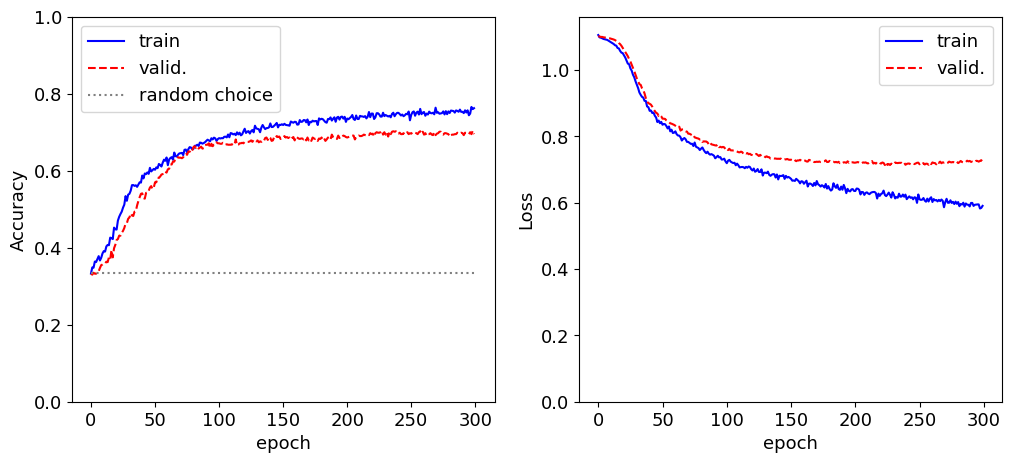

NameError: name 'fit2' is not defined

In [13]:

Show_history(fit)
Show_history(fit2)

Show_weights(model,0,label="model1")
Show_weights(model2,0,label="model2")
Show_weights(model,2,label="model1")
Show_weights(model2,2,label="model2")


y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val, label="Model 1")
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")